# **AML Challenge: Model Stitching**

In [ ]:
# @title
from PIL import Image
import os
from urllib.request import urlopen
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms

from sentence_transformers import SentenceTransformer, util
from diffusers import AutoencoderKL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Downloading the Text Encoder**

In [ ]:
print("🫁 Downloading the model...")
text_encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

🫁 Downloading the model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### **Demo for the Text Encoder:**

In [ ]:
text = "A cat is hiding under the table"

# We obtain the "embedding vector" using the encode() function:
emb = text_encoder.encode(text, convert_to_tensor=True, show_progress_bar=False)

# This is only for clarity:
preview = emb.tolist()[:3] + ["..."] + emb.tolist()[-3:]
print(f"The embedding looks like this: {preview}")

# This is the shape of our embedding:
print(f"The shape of the embedding is: {emb.shape}")

The embedding looks like this: [0.06564971804618835, 0.07378213852643967, -0.029973773285746574, '...', -0.007066949736326933, 0.007970692589879036, 0.10162463784217834]
The shape of the embedding is: torch.Size([384])


## **Downloading the VAE**

In [ ]:
print("🫁 Downloading VAE from Hugging Face...")
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)

🫁 Downloading VAE from Hugging Face...


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

### **Demo for the VAE:**

In [ ]:
IMG_URL = "https://images.unsplash.com/photo-1574144611937-0df059b5ef3e?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=764"
img = Image.open(urlopen(IMG_URL)).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize((256, 256)), # --> keep this size fixed
    # The VAE works also for 512x512, but it will require more compute
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
img_tensor = preprocess(img).unsqueeze(0).to(device)


# Encode --> latent
with torch.no_grad():
    latents = vae.encode(img_tensor).latent_dist.sample() * 0.18215
print("Latent shape:", latents.shape)

# Decode --> reconstruct
with torch.no_grad():
    recon = vae.decode(latents / 0.18215).sample

recon = (recon.clamp(-1, 1) + 1) / 2
recon_img = transforms.ToPILImage()(recon.squeeze().cpu())

Latent shape: torch.Size([1, 4, 32, 32])


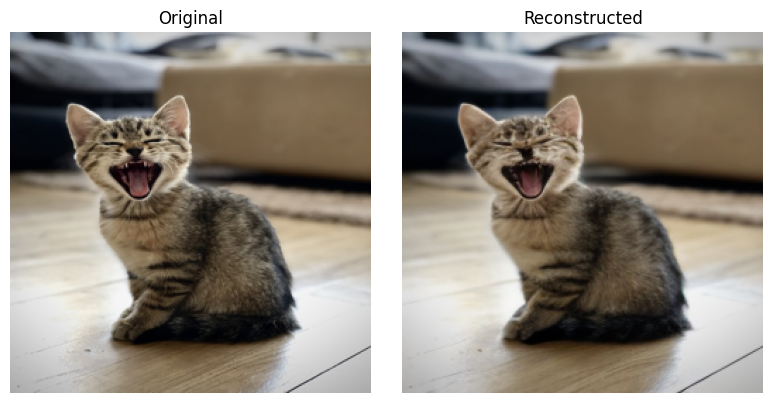

In [ ]:
# Visualize input vs output:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img.resize((256, 256)))
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(recon_img)
axes[1].set_title("Reconstructed")
axes[1].axis("off")

plt.tight_layout()
plt.show()

#**Frankenstein Model:**

In [ ]:
class Translator(nn.Module):
    """
    This will be the Translator Model you have to design for the challenge.
    You have (almost) complete freedom on this. Your creativity will be rewarded.

    Some ideas might be:
    - Zero shot stitching (see https://arxiv.org/pdf/2209.15430)
    - Linear, Affine, Orthognal solutions (see https://arxiv.org/pdf/2311.00664)
    - Diffusion Priors (see https://arxiv.org/pdf/2204.06125)
    - Flow Matching (see https://arxiv.org/pdf/2412.15213)
    - CKA / Procrustes Analysis
    - Adversarial Trainings
    - AutoEncoding Solutions
    """

    def __init__(self):
        super().__init__()
        # Here is where *you* come into play:
        self.fc = nn.Linear(384, 4 * 32 * 32)
        # This is the most trivial thing you can do (spoiler: it doesn't work)

    def forward(self, x):
        x = self.fc(x)
        return x.view(1, 4, 32, 32)

translator = Translator().to(device)
translator.eval()

Translator(
  (fc): Linear(in_features=384, out_features=4096, bias=True)
)

Prompt: Frankestein's Monster writing code on Google Colab
Text embedding shape: torch.Size([384])
Translated latent shape: torch.Size([1, 4, 32, 32])




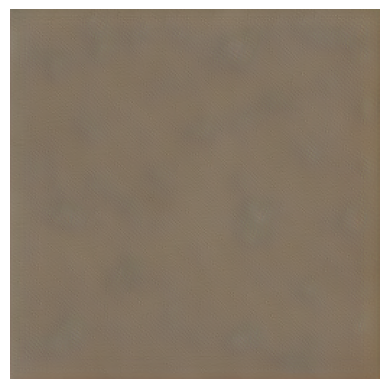

In [ ]:
# Part 1: encoding the text prompt
text = "Frankestein's Monster writing code on Google Colab"
print(f"Prompt: {text}")
emb = text_encoder.encode(text, convert_to_tensor=True).to(device)
print("Text embedding shape:", emb.shape)

# Part 2: translating the embedding
with torch.no_grad():
    latent = translator(emb)
print(f"Translated latent shape: {latent.shape}\n\n")

# Part 3: feed the VAE with the translation
with torch.no_grad():
    recon = vae.decode(latent / 0.18215).sample

# Part 4: visualizing the output
recon = (recon.clamp(-1, 1) + 1) / 2
recon_img = transforms.ToPILImage()(recon.squeeze().cpu())

plt.imshow(recon_img)
plt.axis("off")
plt.show()

## Baseline

In [ ]:
!mkdir data
!gdown 1CVAQDuPOiwm8h9LJ8a_oOs6zOWS6EgkB
!gdown 1ykZ9fjTxUwdiEwqagoYZiMcD5aG-7rHe
!unzip -o test.zip -d data
!unzip -o train.zip -d data

!git clone https://github.com/Mamiglia/challenge.git

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm import tqdm

from challenge.src.common import load_data, prepare_train_data, generate_submission

In [ ]:
# Configuration
MODEL_PATH = "models/mlp_baseline.pth"
EPOCHS = 20
BATCH_SIZE = 256
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
class MLP(nn.Module):
    def __init__(self, input_dim=1024, output_dim=1536, hidden_dim=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
import torch.nn.functional as F

def train_model(model, train_loader, val_loader, device, epochs, lr):
    """Train the MLP model"""
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)

            loss = F.mse_loss(outputs, y_batch)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = F.mse_loss(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"  ✓ Saved best model (val_loss={val_loss:.6f})")

    return model

In [ ]:
# Load data
train_data = load_data("data/train/train.npz")
X, y, label = prepare_train_data(train_data)
DATASET_SIZE = len(X)
# Split train/val
# This is done only to measure generalization capabilities, you don't have to
# use a validation set (though we encourage this)
n_train = int(0.9 * len(X))
TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
y_train.shape[-1], X_val.shape[-1]

In [ ]:
model = MLP().to(DEVICE)
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train
print("\n3. Training...")
model = train_model(model, train_loader, val_loader, DEVICE, EPOCHS, LR)

# Load best model for evaluation
model.load_state_dict(torch.load(MODEL_PATH))

In [ ]:
from challenge.src.eval import visualize_retrieval
import numpy as np
import torch

val_caption_text = train_data['captions/text'][~TRAIN_SPLIT]
val_text_embd = X_val
img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
val_img_file = train_data['images/names'][img_VAL_SPLIT]
val_img_embd = torch.from_numpy(train_data['images/embeddings'][img_VAL_SPLIT])
val_label = np.nonzero(train_data['captions/label'][~TRAIN_SPLIT][:,img_VAL_SPLIT])[1]

# Sample and visualize
for i in range(5):
    idx = np.random.randint(0, 100)
    caption_embd = val_text_embd[idx]
    caption_text = val_caption_text[idx]
    gt_index = val_label[idx]

    with torch.no_grad():
        pred_embds = model(caption_embd.to(DEVICE)).cpu()

        visualize_retrieval(
            pred_embds,
            gt_index,
            val_img_file,
            caption_text, val_img_embd, k=5)

In [ ]:
test_data = load_data("data/test/test.clean.npz")

test_embds = test_data['captions/embeddings']
test_embds = torch.from_numpy(test_embds).float()

with torch.no_grad():
    pred_embds = model(test_embds.to(DEVICE)).cpu()

submission = generate_submission(test_data['captions/ids'], pred_embds, 'submission.csv')
print(f"Model saved to: {MODEL_PATH}")